In [64]:
import obspy
import matplotlib.pyplot as plt
import numpy as np
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")

In [65]:
def mk_baz_from_stream_group(baz_bin_size):
    """
    Makes a dictionary of baz values with empty Stream() as values
    Input: baz_bin_size (int) - the size of the bins in degrees
    Output: baz_dict (dict) - a dictionary with baz values as keys and empty lists as values
    """

    baz_dict = {}
    baz_list = np.arange(0, 361, baz_bin_size)  # we used 361 to include 360
    for baz in baz_list:
        baz_dict[baz] = obspy.Stream()
    return baz_dict


###################################################################################################################
def mk_slowness_from_stream_group(slowness_bin_size, stream, hist_on=True):
    """
    Makes a dictionary of slowness values with empty Stream() as values
    Input: slowness_bin_size (int) - the size of the bins in degrees
    Output: baz_dict (dict) - a dictionary with baz values as keys and empty lists as values
    """

    #figure out the distribution of slowness values
    slowness_list = []
    for tr in stream:
        depth = tr.stats.sac.evdp/1000
        distance = tr.stats.sac.gcarc
        slowness = model.get_travel_times(source_depth_in_km=depth, distance_in_degree=distance, phase_list=["P"])[0].ray_param/110
        slowness_list.append(slowness)
        
    
    slowness_list = np.array(slowness_list)
    #plotting the histogram
    if hist_on:
        plt.hist(slowness_list, bins=slowness_bin_size)
        plt.xlabel('Slowness (s/km)')
        plt.ylabel('Count')

    min_slowness = np.min(slowness_list)
    max_slowness = np.max(slowness_list)
    slowness_list = np.around(np.arange(min_slowness, max_slowness+0.01, slowness_bin_size))
    slowness_dict = {}
    
    for slowness in slowness_list:
        slowness_dict[slowness] = obspy.Stream()
    return slowness_dict


###################################################################################################################
def polar_baz_histogram(obspy_stream, bin_size):
    """
    Makes a polar histogram of baz values for a given stream
    Input: obspy_stream (obspy stream) - the stream to be analyzed
           bin_size (int) - the size of the bins in degrees
    Output: None (plots a polar histogram)
    """
    
    #first step is to make a list of baz values from the stream
    BAZ = []
    for tr in st:
        try:
            baz = tr.stats.sac.baz
            BAZ.append(baz)
        except:
            print(f"BAZ not found for {tr.stats.station}")
    if len(BAZ) == 0:
        raise Exception("None of traces has the baz value. Check if the baz value is in the sac header.")

    #plotting the histogram
    hist_bin = int(bin_size*3)
    hist, bin_edges = np.histogram(BAZ, bins=hist_bin, range=(0, 360))
    theta = np.linspace(0.0, 2 * np.pi, hist_bin, endpoint=False)
    colors = plt.cm.viridis(hist / 10.)
    ax = plt.subplot(111, projection='polar')
    ax.bar(theta, hist, color=colors, alpha=0.6)
    ax.set_xticks(theta)
    ax.set_title(f"BAZ distribution for {st[0].stats.station}")


###################################################################################################################
def find_closest_baz(baz_dict, baz):
    """
    Finds the closest baz value in the baz_dict to the given baz value
    Input: baz_dict (dict) - a dictionary of baz values with empty Stream() as values
           baz (int) - the baz value to be compared to the baz values in the baz_dict
    Output: closest_baz (int) - the closest baz value in the baz_dict to the given baz value
    """
    baz_list = list(baz_dict.keys())
    for i in range(len(baz_list)):
        if baz <= baz_list[i]:
            return baz_list[i-1]
            break
    

###################################################################################################################
def plotting_rf_binns(st, dict_binned, mode='baz', gain = 100, xlim=[40, 70], p_time=42.6):
    """
    Plots the stacked waveforms for each bin in the baz_dict
    Input: st (obspy stream) - the stream to be analyzed
    dict_binned (dict) - a dictionary of baz values with empty Stream() as values
    mode (str) - the mode of binning. Options are 'baz' and 'slowness'
    gain (int) - the gain for the stacked waveforms
    xlim (list) - the x limits for the plot
    p_time (float) - the p wave arrival time

    Output: None (plots the stacked waveforms)
    """
    
    
    for tr in st:
        if mode == 'baz':
            mode_value = float(tr.stats.sac.baz)
        elif mode == 'slowness':
            depth = tr.stats.sac.evdp/1000
            distance = tr.stats.sac.gcarc
            mode_value = model.get_travel_times(source_depth_in_km=depth, distance_in_degree=distance, phase_list=["P"])[0].ray_param/110
            print(mode_value)
        if find_closest_baz(dict_binned, mode_value):
            dict_binned[find_closest_baz(dict_binned, mode_value)] += tr
    #stacking
    for mode_value in dict_binned.keys():
        if len(dict_binned[mode_value]) > 1:
            dict_binned[mode_value].stack()
            # dict_binned[mode_value][0].stats.baz = mode_value
    for tr_key in dict_binned.keys():
        tr = dict_binned[tr_key]
        if len(tr) > 0:
            mode_value = tr_key
            signal = tr[0].data
            time = tr[0].times()
            signal_corr = signal*gain+mode_value
            sig_avg = mode_value
            plt.plot(time, signal_corr, 'k', linewidth=0.5)
            plt.fill_between(time, signal_corr, sig_avg, where=signal_corr>=sig_avg, color='r', interpolate=True)
            plt.fill_between(time, signal_corr, sig_avg, where=signal_corr<sig_avg, color='b', interpolate=True)
            plt.axvline(p_time, color='k', linestyle=':', linewidth=1.5)
        
    plt.xlabel('Time (s)')
    if mode == 'baz':
        plt.ylabel('BAZ (degrees)')
    elif mode == 'slowness':
        plt.ylabel('Slowness (s/km)')
    plt.title('Stacked waveforms')
    plt.xlim(xlim[0], xlim[1])
    dict_binned_stacked = dict_binned
    return dict_binned_stacked
    

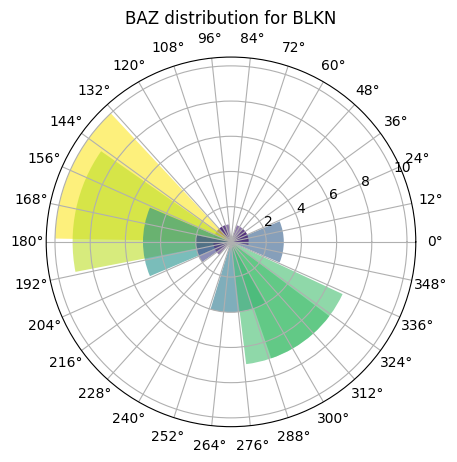

In [66]:
with open("DB/04_paths_quality_3.txt", 'r') as f:
    QC_file = f.readlines()

#Reading waveform and group them based on baz and then plot them together

baz_dict = {}
st = obspy.Stream()
for i in range(len(QC_file)):
    path = QC_file[i].strip()
    st += obspy.read(path)

#BAZ histogram - polar plot
baz_bin_size = 10
polar_baz_histogram(st, baz_bin_size)




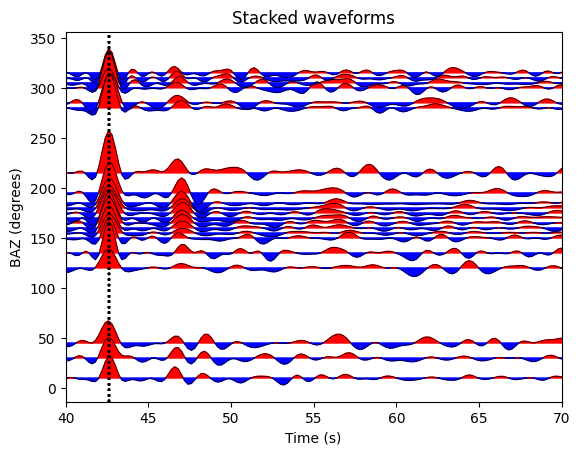

In [67]:
baz_bin_size = 5
baz_dict = mk_baz_from_stream_group(baz_bin_size)  # make a dictionary of baz values with empty Stream() lists as values

#plotting the stacked waveforms for BAZ mode
dict_binned_stacked = plotting_rf_binns(st, baz_dict, mode='baz', gain = 200, xlim=[40, 70], p_time=42.6)

3.467045512602053
3.759370697232898
2.8466820927842797
2.9642705883353098
3.252862517932113
3.379264266239612
3.7916014857345233
3.5878475481166454
4.575323854102993
3.6600870345349947
3.929318458378835
3.8819942209917957
2.7830808287156494
3.120585530965561
3.724046564726151
4.084554455542915
4.035715468282207
4.542734857071984
4.4462154875745385
2.7270502887030803
4.113695794332852
4.097372275215667
3.8656135834377165
4.231825394267239
4.58084752593268
3.978314729912712
4.139887148784571
2.9806859521882623
3.964210619296182
2.948526561106052
4.585263844293715
2.750298706763401
4.105365001827922
3.942760455812498
3.708157488628781
4.095342830515527
3.9583056969901307
3.1801731135443823
3.6717224564030135
4.110183134440249
4.018450492377413
4.150300703499227
4.049226336269678
2.8026545407179735
3.978580869058732
2.860753840210812
2.563432685388361
3.841143471026113
2.8317716140440905
3.911076922990193
4.254540964636224
3.6507367814126503
2.8722761013980036
3.9076549272893337


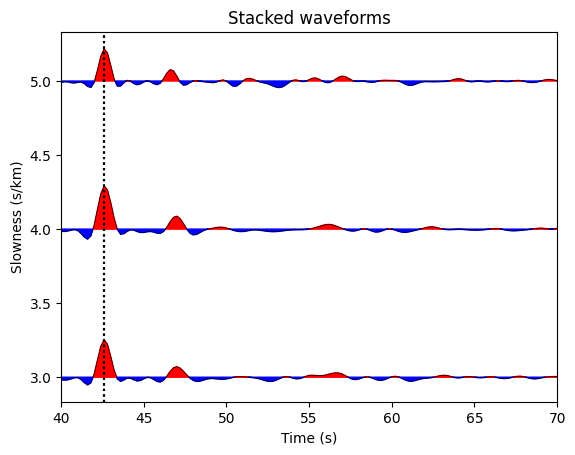

In [68]:
slowness_bin_size = 0.01
slowness_dict = mk_slowness_from_stream_group(slowness_bin_size, st, hist_on = False)  # make a dictionary of slowness values with empty Stream() lists as values

#plotting the stacked waveforms for slowness mode
dict_binned_stacked = plotting_rf_binns(st, slowness_dict, mode='slowness', gain = 2, xlim=[40, 70], p_time=42.6)